In [1]:
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), 'Main'))
	print(os.getcwd())
except:
	pass

In [2]:
from IPython import get_ipython
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 400)
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')
import re
from sklearn.feature_extraction.text import TfidfVectorizer


In [3]:
# Fetch dataset
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english', min_df=4)
news_tfidf = vectorizer.fit_transform(newsgroups_train.data)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=20

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    topwords=pd.Series()
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        #print(chosen)
        # Combine loading and index into a string.
        for i, data in enumerate(chosen):
            chosenlist=chosen.index.values.tolist()[i] +" "+ str(round(data ,2))
            topwords = topwords.append(pd.Series([chosenlist], index=[column]))
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10


 In addition to creating the tfidf matrix, there are two convenience functions that will help keep the code tidy when comparing models.  The first provides a list of the words that are paired with each topic.  The second gives us the best words for each topic so we can compare across methods.

 ## Fitting the three topic extraction models

In [4]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
news_lsa = lsa.fit_transform(news_tfidf)

components_lsa = word_topic(news_tfidf, news_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                



In [5]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

news_lda = lda.fit_transform(news_tfidf) 

components_lda = word_topic(news_tfidf, news_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

In [6]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
news_nmf = nmf.fit_transform(news_tfidf) 

components_nmf = word_topic(news_tfidf, news_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)


 We are mostly using the default settings for each method, but explicitly printing them so it is clear what is going on and how each model can be modified.  sklearn has such nice parallel structure for its various topic extraction methods that we could probably have abstracted the code even further.

 # Inspecting the topics

 For each topic, we list the ten most-relevant words according to each method:

In [7]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])
    


Topic 0:
                   LSA                 LDA          NNMF
0           edu 243.63            edu 92.1      car 2.77
0            com 169.6           com 78.39      edu 1.94
0        subject 105.7           god 59.05      com 1.77
0         lines 104.89        people 53.27     bike 1.25
0  organization 103.67        writes 46.41     like 1.06
0         writes 97.91       article 43.01      new 1.04
0        article 96.35           don 41.96     just 1.02
0     university 92.44       subject 40.86     good 1.01
0            don 84.79         lines 40.07  subject 0.98
0           like 84.47  organization 39.31    lines 0.98
Topic 1:
                LSA                LDA            NNMF
1         god 47.97           edu 5.44        god 8.86
1       people 28.7           com 3.68      jesus 3.78
1       jesus 22.82       subject 2.44      bible 2.47
1       bible 15.15         lines 2.42         edu 2.4
1   christian 14.71  organization 2.39     people 2.26
1  christians 14.44      

 A number of things are clear.
 First, some topics are shared, though the order of topics varies- the 'oh' topic is first for LSA and NNMF, but second for LDA.
 And second, the content of some of the topics varies considerably across methods.
 This is a clear argument for using multiple methods when exploring topics.

 # Sparsity

 Now let's examine sparsity by looking at the distributions of loadings for the words 'marriage', 'love', 'emma', and 'oh' across the methods:

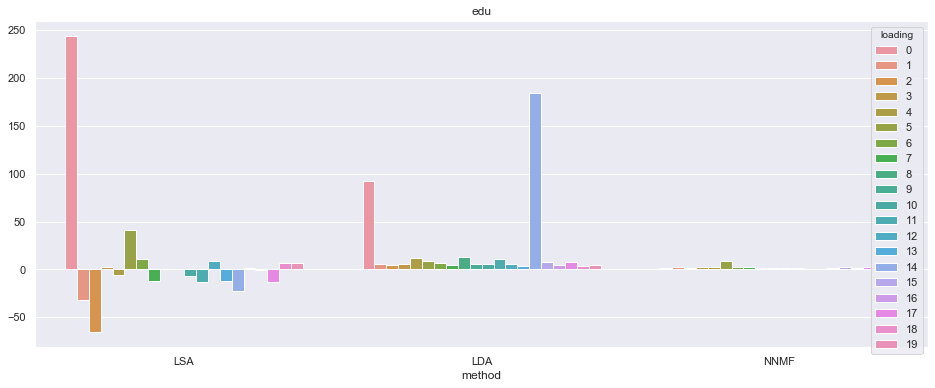

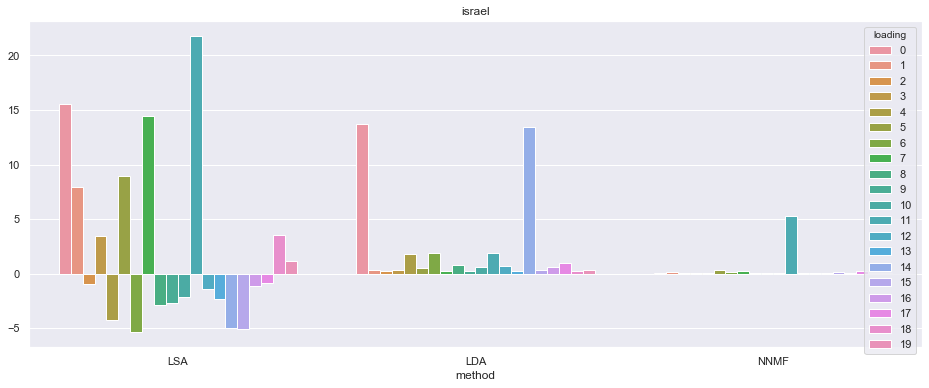

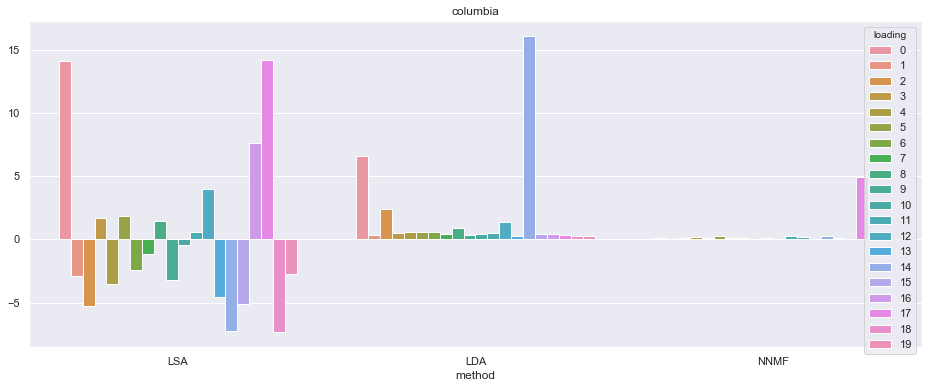

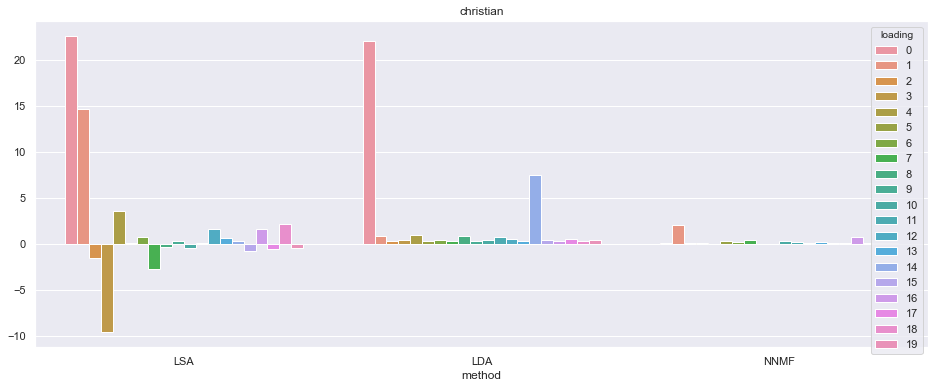

In [8]:
# The words to look at.
targetwords=['edu','israel','columbia','christian']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 20, axis=0)
wordloadings['loading']=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]*3

sns.set(style="darkgrid")

for word in targetwords:
    plt.figure(figsize=(16, 6))
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    
    plt.title(word)
    plt.ylabel("")
    plt.show()